In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch

# Directories for real and fake videos
real_videos_dir = '/kaggle/input/reduced-celebdf/Reduced_CelebDF/real_videos'
fake_videos_dir = '/kaggle/input/reduced-celebdf/Reduced_CelebDF/fake_videos'

# Frame extraction function
def extract_frames(video_path, label, frames_dir):
    cap = cv2.VideoCapture(video_path)
    count = 0
    extracted_frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Save frame every nth frame (to reduce processing load)
        if count % 10 == 0:  # Change 10 to adjust frequency
            frame_path = os.path.join(frames_dir, f"{os.path.basename(video_path)}_frame{count}.jpg")
            cv2.imwrite(frame_path, frame)
            extracted_frames.append((frame_path, label))
        count += 1
    cap.release()
    return extracted_frames

# Prepare dataset
def prepare_dataset(real_videos_dir, fake_videos_dir, frames_dir):
    os.makedirs(frames_dir, exist_ok=True)
    dataset = []
    # Extract frames from real videos
    for video in os.listdir(real_videos_dir):
        video_path = os.path.join(real_videos_dir, video)
        dataset.extend(extract_frames(video_path, label=0, frames_dir=frames_dir))  # 0 for real
    # Extract frames from fake videos
    for video in os.listdir(fake_videos_dir):
        video_path = os.path.join(fake_videos_dir, video)
        dataset.extend(extract_frames(video_path, label=1, frames_dir=frames_dir))  # 1 for fake
    return dataset

# Custom dataset class
class FrameDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        frame_path, label = self.data[idx]
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if self.transform:
            frame = self.transform(frame)
        return frame, torch.tensor(label, dtype=torch.long)

# Frame storage directory
frames_dir = '/kaggle/working/extracted_frames'

# Prepare the dataset
dataset = prepare_dataset(real_videos_dir, fake_videos_dir, frames_dir)

# Train-test split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, stratify=[label for _, label in dataset])

# Data transformations (optional)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create PyTorch data loaders
train_loader = DataLoader(FrameDataset(train_data, transform=transform), batch_size=32, shuffle=True)
test_loader = DataLoader(FrameDataset(test_data, transform=transform), batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Total frames: {len(dataset)}")
print(f"Train frames: {len(train_data)}")
print(f"Test frames: {len(test_data)}")


Total frames: 2142
Train frames: 1713
Test frames: 429


In [2]:
train_loader_size = len(train_loader)
test_loader_size = len(test_loader)

print(f"Train loader size (number of batches): {train_loader_size}")
print(f"Test loader size (number of batches): {test_loader_size}")


Train loader size (number of batches): 54
Test loader size (number of batches): 14


In [4]:
pip install timm


Note: you may need to restart the kernel to use updated packages.


In [9]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the Xception model from timm
model = timm.create_model('xception', pretrained=True)
model.classifier = nn.Linear(model.get_classifier().in_features, 2)  # Adjust for binary classification
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Check if the model loads correctly
print(model)


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

Epoch 1/10, Train Loss: 0.9665, Test Loss: 0.6737
Epoch 2/10, Train Loss: 0.2679, Test Loss: 0.2454
Epoch 3/10, Train Loss: 0.1300, Test Loss: 0.1392
Epoch 4/10, Train Loss: 0.0640, Test Loss: 0.1066
Epoch 5/10, Train Loss: 0.0583, Test Loss: 0.0442
Epoch 6/10, Train Loss: 0.0497, Test Loss: 0.2031
Epoch 7/10, Train Loss: 0.0482, Test Loss: 0.2483
Epoch 8/10, Train Loss: 0.0389, Test Loss: 0.1188
Epoch 9/10, Train Loss: 0.0435, Test Loss: 0.0617
Epoch 10/10, Train Loss: 0.0013, Test Loss: 0.0728

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      0.93      0.96        95
        Fake       0.98      1.00      0.99       334

    accuracy                           0.98       429
   macro avg       0.99      0.96      0.98       429
weighted avg       0.98      0.98      0.98       429



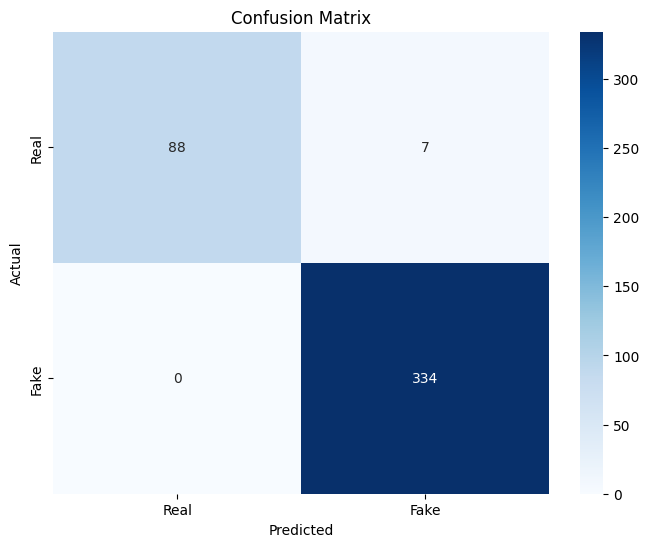

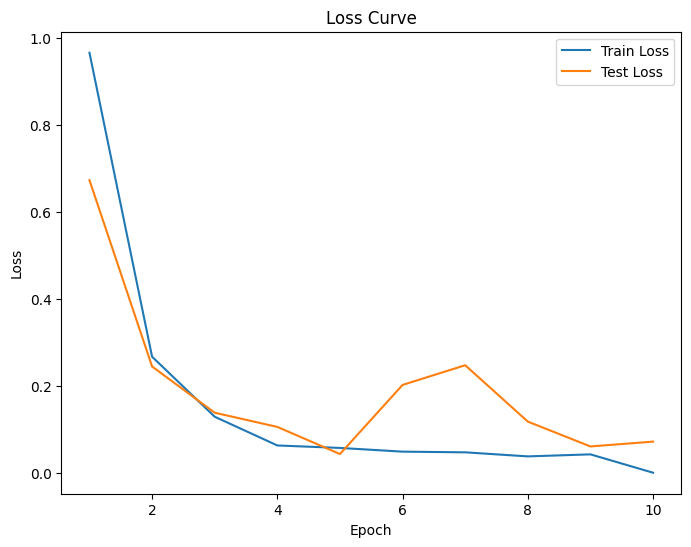

Model saved as 'xception_model.pth'


In [10]:
# Define training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize variables for tracking loss
train_losses = []
test_losses = []

# Training and evaluation loop
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))

    # Print epoch results
    print(f"Epoch {epoch+1}/{10}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), train_losses, label="Train Loss")
plt.plot(range(1, 11), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), "xception_model.pth")
print("Model saved as 'xception_model.pth'")
